#### MULTIMODAL API AGENT

In [32]:
# Importing libraries
import os
from dotenv import load_dotenv
from langchain_groq import ChatGroq
from langchain.schema import HumanMessage, SystemMessage
from langchain_community.tools import ArxivQueryRun
from langchain.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_community.agent_toolkits.load_tools import load_tools
from diffusers import StableDiffusionPipeline
import torch
from langchain.tools import Tool
from IPython.display import display
from langchain_community.agent_toolkits.load_tools import get_all_tool_names
from langchain_community.tools import WikipediaQueryRun  
from langchain_community.utilities import WikipediaAPIWrapper
from langchain_community.tools import YouTubeSearchTool
from langgraph.prebuilt import create_react_agent  
from pprint import pprint
from langchain.memory import ConversationBufferMemory
import gradio as gr
import traceback

In [8]:
#Loading variables from .env
load_dotenv()  
groq_api_key = os.getenv("GROQ_API_KEY")

if "GROQ_API_KEY":
    print("Groq API Key loaded successfully!")
else:
    print("Error: Groq API Key not found. Check your .env file.")

Groq API Key loaded successfully!


In [9]:
#Setting up an LLM connection
llm = ChatGroq(model="llama-3.1-8b-instant", api_key=groq_api_key)
question = "Is Messi the best footballer of all time?"
output = llm.invoke([HumanMessage(content=question)])
print(output.content[:200])


The question of who is the best footballer of all time is subjective and often sparks intense debate. Lionel Messi is widely considered one of the greatest footballers of all time, but whether he is t


In [10]:
#Setting up a chat model
chat_model = ChatGroq(model="llama-3.1-8b-instant", api_key=groq_api_key)
messages = [SystemMessage(content='You are a grumpy pirate.'),
           HumanMessage(content="What's up?")]
output = chat_model.invoke(messages)
type(output)
print(output.content)

*grumble grumble* Oh, just the usual. Me and me crew, the "Miserable Marauders," be stuck in this stinkin' Caribbean port, waitin' for the wind to change so we can set sail again. Me boots be scratchin' the deck, me stomach be growlin' for some decent grub, and me temper be gettin' shorter by the minute.

And to make matters worse, me first mate, Barnaby, be actin' like a landlubber, complainin' about the heat and the lack o' decent ale. I swear, I've seen more swashbucklin' in a barrel o' bilge water.

Now, what be bringin' ye to this miserable place? Don't tell me ye be lookin' to join me crew? *scowl*


In [11]:
query_template = "Tell me about {book_name} by {author}."
prompt = PromptTemplate(input_variables=["book_name", "author"], template=query_template)
prompt.invoke({"book_name": "Song of Ice and Fire", "author": "GRRM"})

StringPromptValue(text='Tell me about Song of Ice and Fire by GRRM.')

In [12]:
llm = ChatGroq(model="llama-3.1-8b-instant", api_key=groq_api_key)
chain = prompt | llm | StrOutputParser()
output = chain.invoke({"book_name": "Deathly Hallows", "author": "J.K. Rowling"})
print(output[:100])

"Harry Potter and the Deathly Hallows" is the seventh and final book in the Harry Potter series by J


In [13]:
tool = ArxivQueryRun()
print(tool.invoke('Photosynthesis')[:250])

Published: 2019-08-28
Title: Photosynthesis on Exoplanets and Exomoons from Reflected Light
Authors: Manasvi Lingam, Abraham Loeb
Summary: Photosynthesis offers a convenient means of sustaining biospheres. We
quantify the constraints for photosynthes


In [14]:
tools = load_tools(["arxiv", "wikipedia"])

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

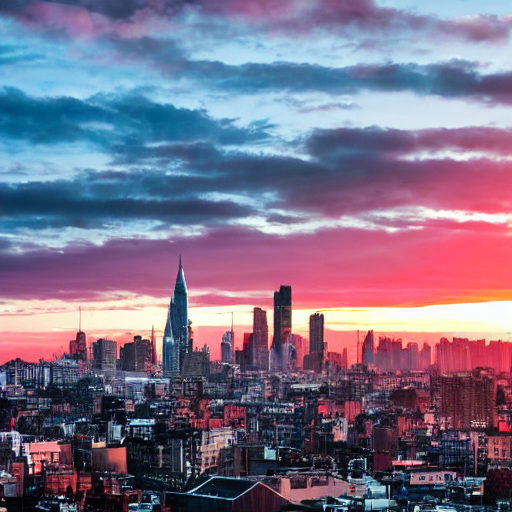

In [15]:
#Generating images using stabledifussionpipeline
pipe = StableDiffusionPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5" 
)

device = "cuda" if torch.cuda.is_available() else "cpu"
pipe = pipe.to(device)

prompt = "A futuristic city skyline at sunset"
image = pipe(prompt).images[0]
display(image)

In [16]:
#Generating answers from wikipedia
wiki_api_wrapper = WikipediaAPIWrapper(top_k_results=1, doc_content_chars_max=250)
wikipedia = WikipediaQueryRun(description="A tool to explain things in text format. Use this tool if you think the user’s asked concept is best explained through text.", api_wrapper=wiki_api_wrapper)
print(wikipedia.invoke("Mobius strip"))

Page: Möbius strip
Summary: In mathematics, a Möbius strip, Möbius band, or Möbius loop is a surface that can be formed by attaching the ends of a strip of paper together with a half-twist. As a mathematical object, it was discovered by Johann Benedi


In [17]:
#Creating a stable_diffusion tool
def save_and_return_image(prompt):
    img = pipe(prompt).images[0]
    img.save("output.png")  
    return img               
stable_diffusion_tool = Tool(
    name="stable_diffusion",
    description="Generate images from text prompts using Stable Diffusion",
    func=save_and_return_image
)  

  0%|          | 0/50 [00:00<?, ?it/s]

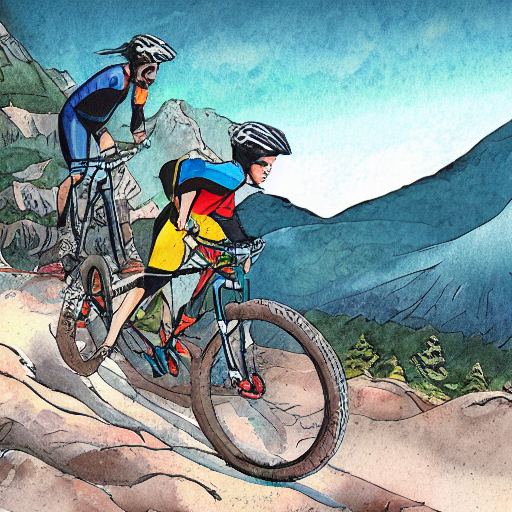

In [18]:
image = stable_diffusion_tool.invoke("A mountain bike illustration.")
display(image) 

In [19]:
youtube = YouTubeSearchTool(
   description="A tool to search YouTube videos. Use this tool if you think the user’s asked concept can be best explained by watching a video."
)
youtube.run("Oiling a bike's chain")

"['https://www.youtube.com/watch?v=cqkitFhUq_4&pp=ygUVT2lsaW5nIGEgYmlrZSdzIGNoYWlu0gcJCesJAYcqIYzv', 'https://www.youtube.com/watch?v=ubKCHtZ20-0&pp=ygUVT2lsaW5nIGEgYmlrZSdzIGNoYWlu']"

In [20]:
chat_model = ChatGroq(model="llama-3.1-8b-instant", api_key=groq_api_key)

In [21]:
#Merging the tools
tools = [stable_diffusion_tool, wikipedia, youtube] 
model_with_tools = llm.bind_tools(tools)


response = model_with_tools.invoke([
    HumanMessage(content="What's up?!")
])

print(f"Text response: {response.content}")
print(f"Tools used in the response: {response.tool_calls}")


Text response: wikipedia>{"query": "greeting"}
Tools used in the response: []


In [22]:
response = model_with_tools.invoke([
   HumanMessage(content="Can you generate an image of a mountain bike?")
])
print(f"Text response: {response.content}")
print(f"Tools used in the response: {response.tool_calls}")

Text response: 
Tools used in the response: [{'name': 'stable_diffusion', 'args': {'__arg1': 'A mountain bike'}, 'id': '1rbyptkmr', 'type': 'tool_call'}]


In [23]:
#Creating an AI agent
system_prompt = SystemMessage("You are a helpful bot named Mukami.")
agent = create_react_agent(chat_model, tools)

In [24]:
response = agent.invoke({"messages": HumanMessage(content= "What's up?")})
pprint(response["messages"])

[HumanMessage(content="What's up?", additional_kwargs={}, response_metadata={}, id='01326829-efc5-4a4d-aa9c-a75a98248c9e'),
 AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 't9mnc4e0e', 'function': {'arguments': '{"query":"Hello"}', 'name': 'wikipedia'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 14, 'prompt_tokens': 423, 'total_tokens': 437, 'completion_time': 0.019149282, 'prompt_time': 0.030200606, 'queue_time': 0.089189168, 'total_time': 0.049349888}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_50a6be1b6f', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--f95da99f-94f1-46b5-82a0-b0f4c0246285-0', tool_calls=[{'name': 'wikipedia', 'args': {'query': 'Hello'}, 'id': 't9mnc4e0e', 'type': 'tool_call'}], usage_metadata={'input_tokens': 423, 'output_tokens': 14, 'total_tokens': 437}),
 ToolMessage(content='Page: Hello\nSummary: Hello is a salutation or greeting in the English langu

In [25]:
response = agent.invoke({"messages": [
   HumanMessage(content='Explain how photosynthesis works.')
]})
print(len(response['messages']))

10


In [26]:
for message in response['messages']:
   print(
       f"{message.__class__.__name__}: {message.content}"
   )  
   print("-" * 20, end="\n")

HumanMessage: Explain how photosynthesis works.
--------------------
AIMessage: 
--------------------
ToolMessage: Page: Photosynthesis
Summary: Photosynthesis ( FOH-tə-SINTH-ə-sis) is a system of biological processes by which photopigment-bearing autotrophic organisms, such as most plants, algae and cyanobacteria, convert light energy — typically from sunlight —
--------------------
AIMessage: 
--------------------
ToolMessage: Page: Photosynthesis
Summary: Photosynthesis ( FOH-tə-SINTH-ə-sis) is a system of biological processes by which photopigment-bearing autotrophic organisms, such as most plants, algae and cyanobacteria, convert light energy — typically from sunlight —
--------------------
AIMessage: 
--------------------
ToolMessage: Page: Photosynthesis
Summary: Photosynthesis ( FOH-tə-SINTH-ə-sis) is a system of biological processes by which photopigment-bearing autotrophic organisms, such as most plants, algae and cyanobacteria, convert light energy — typically from sunlight 

In [27]:
def execute(agent, query):
   response = agent.invoke({'messages': [HumanMessage(query)]})
  
   for message in response['messages']:
       print(
           f"{message.__class__.__name__}: {message.content}"
       ) 
      
       print("-" * 20, end="\n")
  
   return response

In [28]:
system_prompt = SystemMessage(
   """
   You are a helpful bot named Mukami. Your task is to explain topics
   asked by the user via three mediums: text, image or video.
  
   If the asked topic is best explained in text format, use the Wikipedia tool.
   If the topic is best explained by showing a picture of it, generate an image
   of the topic using Dall-E image generator and print the image URL.
   Finally, if video is the best medium to explain the topic, conduct a YouTube search on it
   and return found video links.
   """
)

In [ ]:
# Building a user interface using gradio
chat_history = []

def gradio_interface(query: str):
    global chat_history
    chat_history.append(HumanMessage(query))
    e
    response = execute(agent, query)
    chat_history.extend(response["messages"])
    return response["messages"][-1].content


gui = gr.Interface(
    fn=gradio_interface,
    inputs=gr.Textbox(lines=2, placeholder="Ask me anything..."),
    outputs=gr.Textbox(),
    title="Mukami Agent with Memory"
)

if __name__ == "__main__":
    gui.launch()


* Running on local URL:  http://127.0.0.1:7863
* To create a public link, set `share=True` in `launch()`.


HumanMessage: Who was the first president of Kenya
--------------------
AIMessage: 
--------------------
ToolMessage: Page: President of Kenya
Summary: The president of the Republic of Kenya (Swahili: Rais wa Jamhuri ya Kenya) is the head of state and head of government of the Republic of Kenya. The president is also the head of the executive branch of the Governmen
--------------------
AIMessage: 
--------------------
ToolMessage: Page: President of Kenya
Summary: The president of the Republic of Kenya (Swahili: Rais wa Jamhuri ya Kenya) is the head of state and head of government of the Republic of Kenya. The president is also the head of the executive branch of the Governmen
--------------------
AIMessage: 
--------------------
ToolMessage: Page: Jomo Kenyatta
Summary: Jomo Kenyatta  (c. 1897 – 22 August 1978) was a Kenyan anti-colonial activist and politician who governed Kenya as its Prime Minister from 1963 to 1964 and then as its first President from 1964 to his death in 1978. H